In [1]:
import numpy as np
import sys
from scipy.signal import find_peaks
from datetime import datetime
from pathlib import Path
import os

In [2]:
sess_data_path = r"C:\Users\Sumiya\Workstation2024\CephData\SR0000014\ses-02_date-20241009"
func_img_header_fname = 'SR0000014_00001.h5'
behav_data_header_fname = '20241009SR0000014.bin'

In [3]:
os.name == 'nt' # Windows system

True

In [4]:
sess_data_path = Path(sess_data_path)

In [5]:
func_img_header_path = sess_data_path / 'funcimg' / func_img_header_fname
behav_data_header_path = sess_data_path / 'behav' / behav_data_header_fname

In [6]:
from barcode_util import read_h5

In [7]:
n_channels = 10
height = 1
# Input variables
main_sample_rate = 9000 # Expected sample rate of main data, in Hz
secondary_sample_rate = 5000 # Expected sample rate of secondary data, in Hz
convert_timestamp_column = 0 # Column that timestamps are located in secondary data

if os.name == 'nt': # Windows system
    sess_data_path = Path(sess_data_path)
else:
    sess_data_path = Path(sess_data_path)

vdaq_signals_file = sess_data_path / 'funcimg' / func_img_header_fname
vdaq_signals_file_fname = func_img_header_fname.split('.')[0]
vdaq_FrameTTL = read_h5(vdaq_signals_file, key_idx=0)
vdaq_FrameTTL = np.array(vdaq_FrameTTL)
vdaq_SyncTTL_ts = np.load(sess_data_path / 'funcimg' / (vdaq_signals_file_fname + '_barcode.npy'))

behav_signals_file = sess_data_path / 'behav' / behav_data_header_fname
arr = np.fromfile(behav_signals_file, dtype=np.float64) # Needs to be float64!
behav_DAQ_data = np.reshape(arr, (-1,n_channels)).T  
behav_signals_file_fname = behav_data_header_fname.split('.')[0]
behav_SyncTTL_ts = np.load(sess_data_path / 'behav' / (behav_signals_file_fname + '_barcode.npy'))


# Pull the barcode row from the data. 1st column is timestamps, second is barcodes
barcode_timestamps_row = 0 # Same for both main and secondary, because we used our own code
barcodes_row = 1 # Same for both main and secondary

main_numpy_barcode = behav_SyncTTL_ts[barcodes_row, :]
secondary_numpy_barcode = vdaq_SyncTTL_ts[barcodes_row, :]

main_numpy_timestamp = behav_SyncTTL_ts[barcode_timestamps_row, :]
secondary_numpy_timestamp = vdaq_SyncTTL_ts[barcode_timestamps_row, :]

In [8]:
vdaq_SyncTTL_ts

array([[    984,    5996,   11009, ..., 4477277, 4482289, 4487302],
       [   4801,    4802,    4803, ...,    5694,    5695,    5696]],
      dtype=int64)

In [9]:
behav_SyncTTL_ts

array([[    1930,    10953,    19975, ..., 10513488, 10522511, 10531534],
       [    4790,     4791,     4792, ...,     5955,     5956,     5957]],
      dtype=int64)

In [18]:
FrameTTL_index, _ = find_peaks(np.abs(np.diff(vdaq_FrameTTL)), height=0.05)

In [17]:
np.diff(vdaq_FrameTTL).max()

0.08453369

In [23]:
vdaq_FrameTTL[20194:20200]

array([-0.01220703, -0.01678467,  0.05859375,  0.05859375, -0.01159668,
       -0.01373291], dtype=float32)

In [20]:
FrameTTL_index[:6]

array([20195, 20197, 20200, 20203, 20207, 20212], dtype=int64)

In [8]:
n_channels = 10

In [9]:
signals_file = behav_data_header_path # shows dialog box and return the path

In [10]:
arr = np.fromfile(signals_file, dtype=np.float64) # Needs to be float64!
arr = np.reshape(arr, (-1,n_channels)).T
data = arr[signals_column,:]

In [11]:
data.min()

-0.08946732179541508

In [12]:
try:
    signals_numpy_data = data # np.load(signals_file)
    signals_located = True
except:
    signals_numpy_data = ''
    print("Signals .npy file not located; please check your filepath")
    signals_located = False

In [13]:
barcode_column = signals_numpy_data #[:, signals_column]
barcode_array = barcode_column #.transpose()
# Extract the indices of all events when TTL pulse changed value.
event_index, _ = find_peaks(np.abs(np.diff(barcode_array)), height=4)
# Convert the event_index to indexed_times to align with later code.
indexed_times = event_index # Just take the index values of the raw data

In [14]:
print(indexed_times)

[    1930     2020     2110 ... 10536225 10536315 10536405]


In [16]:
events_time_diff = np.diff(indexed_times) * sample_conversion # convert to ms
wrapper_array = indexed_times[np.where(
                np.logical_and(min_wrap_duration < events_time_diff,
                            events_time_diff  < max_wrap_duration))[0]]

# Isolate the wrapper_array to wrappers with ON values, to avoid any
# "OFF wrappers" created by first binary value.
false_wrapper_check = np.diff(wrapper_array) * sample_conversion # Convert to ms
# Locate indices where two wrappers are next to each other.
nexttoeachother = np.where(np.abs(np.diff(false_wrapper_check)) < ind_wrap_duration * global_tolerance)[0]
# false_wrapper_check[nexttoeachother+1] = np.nan

In [17]:
false_wrapper_check[nexttoeachother+1] = np.nan
false_wrappers = np.where(
                false_wrapper_check < max_wrap_duration)[0]

# Delete the "second" wrapper (it's an OFF wrapper going into an ON bar)
# wrapper_array = np.delete(wrapper_array, false_wrappers+1)
wrapper_array = wrapper_array[false_wrappers]

# Find the barcode "start" wrappers, set these to wrapper_start_times, then
# save the "real" barcode start times to signals_barcode_start_times, which
# will be combined with barcode values for the output .npy file.
# wrapper_time_diff = np.diff(wrapper_array) * sample_conversion # convert to ms
# barcode_index = np.where(wrapper_time_diff < wrap_duration)[0] # total_barcode_duration
wrapper_start_times = wrapper_array #[barcode_index]
signals_barcode_start_times = wrapper_start_times # - ind_wrap_duration / sample_conversion
# Actual barcode start is 10 ms before first 10 ms ON value.

In [18]:
wrapper_start_times

array([    1930,     6530,    10953, ..., 10527112, 10531534, 10536135],
      dtype=int64)

In [ ]:

# Using the wrapper_start_times, collect the rest of the indexed_times events
# into on_times and off_times for barcode value extraction.
on_times = []
off_times = []
for idx, ts in enumerate(indexed_times):    # Go through indexed_times
    # Find where ts = first wrapper start time
    if ts == wrapper_start_times[0]:
        # All on_times include current ts and every second value after ts.
        on_times = indexed_times[idx::2]
        off_times = indexed_times[idx+1::2] # Everything else is off_times

# Convert wrapper_start_times, on_times, and off_times to ms
wrapper_start_times = wrapper_start_times * sample_conversion
on_times = on_times * sample_conversion
off_times = off_times * sample_conversion

signals_barcodes = []

In [43]:
start_time = wrapper_start_times[23]

In [44]:
for start_time in wrapper_start_times:
    oncode = on_times[
        np.where(
            np.logical_and(on_times > start_time,
                        on_times < start_time + total_barcode_duration)
        )[0]
    ]
    offcode = off_times[
        np.where(
            np.logical_and(off_times > start_time,
                        off_times < start_time + total_barcode_duration)
        )[0]
    ]
    curr_time = offcode[0] + 2*ind_wrap_duration # Jumps ahead to start of barcode
    bits = np.zeros((nbits,))
    interbit_OFF = False # Changes to "True" during multiple OFF

    for bit in range(0, nbits):
        next_on = np.where(oncode >= (curr_time - ind_bar_duration * global_tolerance))[0]
        next_off = np.where(offcode >= (curr_time - ind_bar_duration * global_tolerance))[0]

        if next_on.size > 1:    # Don't include the ending wrapper
            next_on = oncode[next_on[0]]
        else:
            next_on = start_time + inter_barcode_interval

        if next_off.size > 1:    # Don't include the ending wrapper
            next_off = offcode[next_off[0]]
        else:
            next_off = start_time + inter_barcode_interval

        # Recalculate min/max bar duration around curr_time
        min_bar_duration = curr_time - ind_bar_duration * global_tolerance
        max_bar_duration = curr_time + ind_bar_duration * global_tolerance

        if min_bar_duration <= next_on <= max_bar_duration:
            bits[bit] = 1
            interbit_OFF = False
        elif min_bar_duration <= next_off <= max_bar_duration:
            interbit_OFF = True
        elif interbit_OFF == False:
            bits[bit] = 1
        # elif min_bar_duration <= next_off < next_on: #interbit_ON == True:
        #     bits[bit] = 1
        # elif next_on < next_off: #interbit_ON == True:
        #     bits[bit] = 0

        curr_time += ind_bar_duration

    barcode = 0

    for bit in range(0, nbits):             # least sig left
        barcode += bits[bit] * pow(2, bit)

    signals_barcodes.append(barcode)

In [45]:
signals_time_and_bars_array = np.vstack((signals_barcode_start_times,
                                        np.array(signals_barcodes)))

In [46]:
np.where(np.array(signals_barcodes) > 5464)

(array([  12,   13,   14, ..., 2314, 2315, 2316], dtype=int64),)

In [47]:
signals_time_and_bars_array[:,1328]

array([6060825.,       0.])

In [48]:
start_time = wrapper_start_times[1328]

In [49]:
oncode = on_times[
    np.where(
        np.logical_and(on_times > start_time,
                    on_times < start_time + total_barcode_duration)
    )[0]
]
offcode = off_times[
    np.where(
        np.logical_and(off_times > start_time,
                    off_times < start_time + total_barcode_duration)
    )[0]
]
curr_time = offcode[0] + 2*ind_wrap_duration # Jumps ahead to start of barcode
bits = np.zeros((nbits,))
interbit_OFF = False # Changes to "True" during multiple OFF

In [50]:
start_time

673425.0

In [42]:
oncode

array([665886. , 665936.2, 666056.4, 666116.6, 666176.6, 666236.8,
       666296.8, 666397.2])

In [43]:
offcode

array([665895.8, 665996.2, 666086.4, 666146.6, 666206.8, 666267. ,
       666387.2, 666407. ])

In [ ]:

for bit in range(0, nbits):
    next_on = np.where(oncode >= (curr_time - ind_bar_duration * global_tolerance))[0]
    next_off = np.where(offcode >= (curr_time - ind_bar_duration * global_tolerance))[0]

    if next_on.size > 1:    # Don't include the ending wrapper
        next_on = oncode[next_on[0]]
    else:
        next_on = start_time + inter_barcode_interval

    if next_off.size > 1:    # Don't include the ending wrapper
        next_off = offcode[next_off[0]]
    else:
        next_off = start_time + inter_barcode_interval

    # Recalculate min/max bar duration around curr_time
    min_bar_duration = curr_time - ind_bar_duration * global_tolerance
    max_bar_duration = curr_time + ind_bar_duration * global_tolerance

    if min_bar_duration <= next_on <= max_bar_duration:
        bits[bit] = 1
        interbit_OFF = False
    elif min_bar_duration <= next_off <= max_bar_duration:
        interbit_OFF = True
    elif interbit_OFF == False:
        bits[bit] = 1
    # elif min_bar_duration <= next_off < next_on: #interbit_ON == True:
    #     bits[bit] = 1
    # elif next_on < next_off: #interbit_ON == True:
    #     bits[bit] = 0

    curr_time += ind_bar_duration

barcode = 0

for bit in range(0, nbits):             # least sig left
    barcode += bits[bit] * pow(2, bit)


In [ ]:
for start_time in wrapper_start_times:
    oncode = on_times[
        np.where(
            np.logical_and(on_times > start_time,
                        on_times < start_time + total_barcode_duration)
        )[0]
    ]
    offcode = off_times[
        np.where(
            np.logical_and(off_times > start_time,
                        off_times < start_time + total_barcode_duration)
        )[0]
    ]
    curr_time = offcode[0] + 2*ind_wrap_duration # Jumps ahead to start of barcode
    bits = np.zeros((nbits,))
    interbit_OFF = False # Changes to "True" during multiple OFF

    for bit in range(0, nbits):
        next_on = np.where(oncode >= (curr_time - ind_bar_duration * global_tolerance))[0]
        next_off = np.where(offcode >= (curr_time - ind_bar_duration * global_tolerance))[0]

        if next_on.size > 1:    # Don't include the ending wrapper
            next_on = oncode[next_on[0]]
        else:
            next_on = start_time + inter_barcode_interval

        if next_off.size > 1:    # Don't include the ending wrapper
            next_off = offcode[next_off[0]]
        else:
            next_off = start_time + inter_barcode_interval

        # Recalculate min/max bar duration around curr_time
        min_bar_duration = curr_time - ind_bar_duration * global_tolerance
        max_bar_duration = curr_time + ind_bar_duration * global_tolerance

        if min_bar_duration <= next_on <= max_bar_duration:
            bits[bit] = 1
            interbit_OFF = False
        elif min_bar_duration <= next_off <= max_bar_duration:
            interbit_OFF = True
        elif interbit_OFF == False:
            bits[bit] = 1
        # elif min_bar_duration <= next_off < next_on: #interbit_ON == True:
        #     bits[bit] = 1
        # elif next_on < next_off: #interbit_ON == True:
        #     bits[bit] = 0

        curr_time += ind_bar_duration

    barcode = 0

    for bit in range(0, nbits):             # least sig left
        barcode += bits[bit] * pow(2, bit)

    signals_barcodes.append(barcode)

In [24]:
offcode

array([7224.6, 7244.4, 7364.8, 7485.2, 7545.4, 7635.6, 7735.8])

In [25]:
curr_time

7244.6

In [26]:
bit = 0

In [29]:

next_on = np.where(oncode >= (curr_time - ind_bar_duration * global_tolerance))[0]
next_off = np.where(offcode >= (curr_time - ind_bar_duration * global_tolerance))[0]

if next_on.size > 1:    # Don't include the ending wrapper
    next_on = oncode[next_on[0]]
else:
    next_on = start_time + inter_barcode_interval

if next_off.size > 1:    # Don't include the ending wrapper
    next_off = offcode[next_off[0]]
else:
    next_off = start_time + inter_barcode_interval

In [30]:
next_on

7334.8

In [31]:
next_off

7244.400000000001

In [32]:


# Recalculate min/max bar duration around curr_time
min_bar_duration = curr_time - ind_bar_duration * global_tolerance
max_bar_duration = curr_time + ind_bar_duration * global_tolerance

if min_bar_duration <= next_on <= max_bar_duration:
    bits[bit] = 1
    interbit_OFF = False
elif min_bar_duration <= next_off <= max_bar_duration:
    interbit_OFF = True
elif interbit_OFF == False:
    bits[bit] = 1
# elif min_bar_duration <= next_off < next_on: #interbit_ON == True:
#     bits[bit] = 1
# elif next_on < next_off: #interbit_ON == True:
#     bits[bit] = 0

In [33]:
bits

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
curr_time += ind_bar_duration

barcode = 0

for bit in range(0, nbits):             # least sig left
    barcode += bits[bit] * pow(2, bit)

signals_barcodes.append(barcode)


In [ ]:
for start_time in wrapper_start_times:
    oncode = on_times[
        np.where(
            np.logical_and(on_times > start_time,
                        on_times < start_time + total_barcode_duration)
        )[0]
    ]
    offcode = off_times[
        np.where(
            np.logical_and(off_times > start_time,
                        off_times < start_time + total_barcode_duration)
        )[0]
    ]
    curr_time = oncode[0] + wrap_duration # ind_wrap_duration # Jumps ahead to start of barcode
    bits = np.zeros((nbits,))
    interbit_OFF = False # Changes to "True" during multiple OFF

    for bit in range(0, nbits):
        next_on = np.where(oncode >= (curr_time - ind_bar_duration * global_tolerance))[0]
        next_off = np.where(offcode >= (curr_time - ind_bar_duration * global_tolerance))[0]

        if next_on.size > 1:    # Don't include the ending wrapper
            next_on = oncode[next_on[0]]
        else:
            next_on = start_time + inter_barcode_interval

        if next_off.size > 1:    # Don't include the ending wrapper
            next_off = offcode[next_off[0]]
        else:
            next_off = start_time + inter_barcode_interval

        # Recalculate min/max bar duration around curr_time
        min_bar_duration = curr_time - ind_bar_duration * global_tolerance
        max_bar_duration = curr_time + ind_bar_duration * global_tolerance

        if min_bar_duration <= next_on <= max_bar_duration:
            bits[bit] = 1
            interbit_OFF = False
        elif min_bar_duration <= next_off <= max_bar_duration:
            interbit_OFF = True
        elif interbit_OFF == False:
            bits[bit] = 1
        # elif min_bar_duration <= next_off < next_on: #interbit_ON == True:
        #     bits[bit] = 1
        # elif next_on < next_off: #interbit_ON == True:
        #     bits[bit] = 0

        curr_time += ind_bar_duration

    barcode = 0

    for bit in range(0, nbits):             # least sig left
        barcode += bits[bit] * pow(2, bit)

    signals_barcodes.append(barcode)


In [37]:
# Find time difference between index values (ms), and extract barcode wrappers.
events_time_diff = np.diff(indexed_times) * sample_conversion # convert to ms
wrapper_array = indexed_times[np.where(
                np.logical_and(min_wrap_duration < events_time_diff,
                                events_time_diff  < max_wrap_duration))[0]]

In [38]:
# Isolate the wrapper_array to wrappers with ON values, to avoid any
# "OFF wrappers" created by first binary value.
false_wrapper_check = np.diff(wrapper_array) * sample_conversion # Convert to ms
# Locate indices where two wrappers are next to each other.

In [44]:
wrapper_array

array([    984,    1034,    3539, ..., 4489957, 4492315, 4492365],
      dtype=int64)

In [43]:
false_wrapper_check

array([ 10. , 501. ,  10. , ...,   9.8, 471.6,  10. ])

In [45]:
nexttoeachother = np.where(np.abs(np.diff(false_wrapper_check)) < global_tolerance)[0]

In [46]:
false_wrapper_check[nexttoeachother+1] = np.nan

In [48]:
false_wrappers = np.where(
                    false_wrapper_check < max_wrap_duration)[0]

In [42]:
# false_wrapper_check = np.delete(false_wrappers, nexttoeachother+1)

IndexError: index 3144 is out of bounds for axis 0 with size 3129

In [49]:
false_wrappers

array([   0,    2,    3, ..., 4917, 4918, 4920], dtype=int64)

In [33]:
# wrapper_array = false_wrapper_check[false_wrappers]

In [50]:
# Delete the "second" wrapper (it's an OFF wrapper going into an ON bar)
wrapper_array = wrapper_array[false_wrappers]
# np.delete(wrapper_array, false_wrappers+1)

In [51]:
wrapper_array

array([    984,    3539,    3589, ..., 4489858, 4489908, 4492315],
      dtype=int64)

In [52]:
wrapper_time_diff = np.diff(wrapper_array) * sample_conversion # convert to ms
barcode_index = np.where(wrapper_time_diff < total_barcode_duration)[0]

In [54]:
# Find the barcode "start" wrappers, set these to wrapper_start_times, then
# save the "real" barcode start times to signals_barcode_start_times, which
# will be combined with barcode values for the output .npy file.
wrapper_time_diff = np.diff(wrapper_array) * sample_conversion # convert to ms
barcode_index = np.where(wrapper_time_diff < total_barcode_duration)[0]
wrapper_start_times = wrapper_array[barcode_index]
signals_barcode_start_times = wrapper_start_times # - ind_wrap_duration / sample_conversion
# Actual barcode start is 10 ms before first 10 ms ON value.

# Using the wrapper_start_times, collect the rest of the indexed_times events
# into on_times and off_times for barcode value extraction.
on_times = []
off_times = []
for idx, ts in enumerate(indexed_times):    # Go through indexed_times
    # Find where ts = first wrapper start time
    if ts == wrapper_start_times[0]:
        # All on_times include current ts and every second value after ts.
        on_times = indexed_times[idx::2]
        off_times = indexed_times[idx+1::2] # Everything else is off_times

# Convert wrapper_start_times, on_times, and off_times to ms
wrapper_start_times = wrapper_start_times * sample_conversion
on_times = on_times * sample_conversion
off_times = off_times * sample_conversion

signals_barcodes = []

In [55]:
wrapper_start_times

array([1.968000e+02, 7.078000e+02, 7.178000e+02, ..., 8.974604e+05,
       8.979716e+05, 8.979816e+05])

In [56]:
start_time = wrapper_start_times[22]

In [57]:
start_time

7214.400000000001

In [58]:
oncode = on_times[
    np.where(
        np.logical_and(on_times > start_time,
                        on_times < start_time + total_barcode_duration)
    )[0]
]
offcode = off_times[
    np.where(
        np.logical_and(off_times > start_time,
                        off_times < start_time + total_barcode_duration)
    )[0]
]
curr_time = oncode[0] + ind_wrap_duration # Jumps ahead to start of barcode
bits = np.zeros((nbits,))
interbit_ON = True # Changes to "True" during multiple ON bars

In [59]:
oncode

array([7234.6, 7334.8, 7425. , 7515. , 7605.2, 7725.8, 7745.6])

In [60]:
offcode

array([7224.6, 7244.4, 7364.8, 7485.2, 7545.4, 7635.6, 7735.8])

In [61]:
curr_time

7244.6

In [33]:
bits

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [48]:
bit = 1

In [49]:
next_on = np.where(oncode >= (curr_time - ind_bar_duration * global_tolerance))[0]
next_off = np.where(offcode >= (curr_time - ind_bar_duration * global_tolerance))[0]

In [50]:
if next_on.size > 1:    # Don't include the ending wrapper
    next_on = oncode[next_on[0]]
else:
    next_on = start_time + inter_barcode_interval

if next_off.size > 1:    # Don't include the ending wrapper
    next_off = offcode[next_off[0]]
else:
    next_off = start_time + inter_barcode_interval

In [51]:
next_on

11314.800000000001

In [52]:
next_off

11375.0

In [53]:
# Recalculate min/max bar duration around curr_time
min_bar_duration = curr_time - ind_bar_duration * global_tolerance
max_bar_duration = curr_time + ind_bar_duration * global_tolerance

In [54]:
min_bar_duration

11291.400000000001

In [55]:
max_bar_duration

11297.400000000001

In [56]:
# Recalculate min/max bar duration around curr_time
min_bar_duration = curr_time - ind_bar_duration * global_tolerance
max_bar_duration = curr_time + ind_bar_duration * global_tolerance

if min_bar_duration <= next_on <= max_bar_duration:
    bits[bit] = 1
    interbit_ON = True
elif min_bar_duration <= next_off <= max_bar_duration:
    interbit_ON = False
elif interbit_ON == True:
    bits[bit] = 1

curr_time += ind_bar_duration

In [57]:
next_on

11314.800000000001

In [58]:
next_off

11375.0

In [59]:
min_bar_duration

11291.400000000001

In [60]:
max_bar_duration

11297.400000000001

In [61]:
bits

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:

for bit in range(0, nbits):
    next_on = np.where(oncode >= (curr_time - ind_bar_duration * global_tolerance))[0]
    next_off = np.where(offcode >= (curr_time - ind_bar_duration * global_tolerance))[0]

    if next_on.size > 1:    # Don't include the ending wrapper
        next_on = oncode[next_on[0]]
    else:
        next_on = start_time + inter_barcode_interval

    if next_off.size > 1:    # Don't include the ending wrapper
        next_off = offcode[next_off[0]]
    else:
        next_off = start_time + inter_barcode_interval

    # Recalculate min/max bar duration around curr_time
    min_bar_duration = curr_time - ind_bar_duration * global_tolerance
    max_bar_duration = curr_time + ind_bar_duration * global_tolerance

    if min_bar_duration <= next_on <= max_bar_duration:
        bits[bit] = 1
        interbit_ON = True
    elif min_bar_duration <= next_off <= max_bar_duration:
        interbit_ON = False
    elif interbit_ON == True:
        bits[bit] = 1

    curr_time += ind_bar_duration

barcode = 0

for bit in range(0, nbits):             # least sig left
    barcode += bits[bit] * pow(2, bit)
print(barcode)

array([11254.6, 11375. , 11495. , 11555.4, 11645.6, 11745.8])

In [24]:
for start_time in wrapper_start_times:
    oncode = on_times[
        np.where(
            np.logical_and(on_times > start_time,
                            on_times < start_time + total_barcode_duration)
        )[0]
    ]
    offcode = off_times[
        np.where(
            np.logical_and(off_times > start_time,
                            off_times < start_time + total_barcode_duration)
        )[0]
    ]
    curr_time = oncode[0] + ind_wrap_duration # Jumps ahead to start of barcode
    bits = np.zeros((nbits,))
    interbit_ON = True # Changes to "True" during multiple ON bars

    for bit in range(0, nbits):
        next_on = np.where(oncode >= (curr_time - ind_bar_duration * global_tolerance))[0]
        next_off = np.where(offcode >= (curr_time - ind_bar_duration * global_tolerance))[0]

        if next_on.size > 1:    # Don't include the ending wrapper
            next_on = oncode[next_on[0]]
        else:
            next_on = start_time + inter_barcode_interval

        if next_off.size > 1:    # Don't include the ending wrapper
            next_off = offcode[next_off[0]]
        else:
            next_off = start_time + inter_barcode_interval

        # Recalculate min/max bar duration around curr_time
        min_bar_duration = curr_time - ind_bar_duration * global_tolerance
        max_bar_duration = curr_time + ind_bar_duration * global_tolerance

        if min_bar_duration <= next_on <= max_bar_duration:
            bits[bit] = 1
            interbit_ON = True
        elif min_bar_duration <= next_off <= max_bar_duration:
            interbit_ON = False
        elif interbit_ON == True:
            bits[bit] = 1

        curr_time += ind_bar_duration

    barcode = 0

    for bit in range(0, nbits):             # least sig left
        barcode += bits[bit] * pow(2, bit)

    signals_barcodes.append(barcode)


In [25]:
signals_barcodes

[4801.0,
 0.0,
 4802.0,
 0.0,
 4803.0,
 0.0,
 4804.0,
 0.0,
 4805.0,
 0.0,
 4806.0,
 0.0,
 4807.0,
 0.0,
 4808.0,
 0.0,
 4809.0,
 0.0,
 4810.0,
 0.0,
 4811.0,
 0.0,
 65535.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4830.0,
 0.0,
 4831.0,
 0.0,
 4832.0,
 0.0,
 4833.0,
 0.0,
 4834.0,
 0.0,
 4835.0,
 0.0,
 4836.0,
 0.0,
 4837.0,
 0.0,
 4838.0,
 0.0,
 4839.0,
 0.0,
 60648.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,

In [54]:
actualbarcode_idx = np.where(np.array(signals_barcodes) >= 1)[0]
signals_time_and_bars_array[:,actualbarcode_idx]

array([[9.840000e+02, 5.996000e+03, 1.100900e+04, ..., 4.487302e+06,
        4.489858e+06, 4.492315e+06],
       [4.801000e+03, 4.802000e+03, 4.803000e+03, ..., 6.553500e+04,
        3.276700e+04, 6.553500e+04]])

In [52]:
betweenbarcode

(array([   1,    3,    5,    7,    9,   11,   13,   15,   17,   19,   21,
          79,   81,   83,   85,   87,   89,   91,   93,   95,   97,   99,
         101,  103,  105,  107,  109,  111,  113,  115,  117,  119,  121,
         123,  125,  127,  129,  131,  133,  135,  137,  139,  141,  143,
         145,  147,  149,  151,  153,  155,  157,  159,  161,  163,  165,
         167,  169,  171,  173,  175,  177,  179,  181,  183,  185,  187,
         189,  191,  193,  195,  197,  199,  201,  203,  205,  207,  209,
         211,  213,  215,  217,  219,  221,  223,  225,  227,  229,  231,
         233,  235,  237,  239,  241,  243,  245,  247,  249,  251,  253,
         255,  257,  259,  261,  263,  265,  267,  269,  271,  273,  275,
         277,  279,  281,  283,  285,  287,  289,  291,  293,  295,  297,
         299,  301,  303,  305,  307,  309,  311,  313,  315,  317,  319,
         321,  323,  325,  327,  329,  331,  333,  335,  337,  339,  341,
         343,  345,  347,  349,  351, 

In [26]:
signals_time_and_bars_array = np.vstack((signals_barcode_start_times,
                                        np.array(signals_barcodes)))

In [29]:
signals_time_and_bars_array[:,22]

array([56073., 65535.])

In [28]:
signals_time_and_bars_array.shape

(2, 1792)

In [23]:
import matplotlib.pyplot as plt

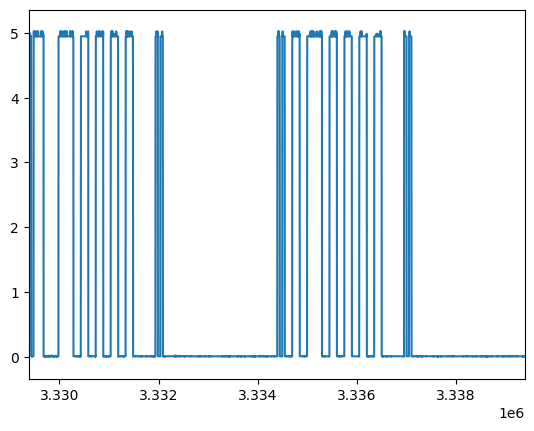

In [24]:
plt.plot(barcode_array)
plt.xlim(3329380,3339380)
plt.show()